Model training data: 4355


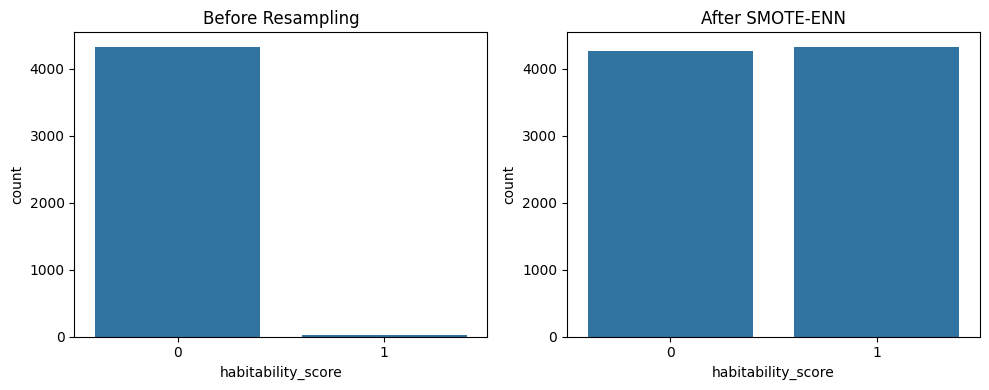

Final class distribution: Counter({1: 4330, 0: 4269})


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.combine import SMOTEENN
from collections import Counter


# ================================
# STEP 0: LOAD PREPROCESSED DATA
# ================================
data = pd.read_csv("final-preprocessed-updated.csv")


# ============================================
# STEP 1: TARGET SELECTION & DATA LEAKAGE FIX
# ============================================
# These columns directly influence habitability score.
# Keeping them would allow the model to cheat.
leak_columns = ['pl_rade', 'pl_insol', 'pl_eqt', 'pl_orbeccen']

# Identifiers that don't help prediction
id_columns = ['pl_name', 'hostname', 'st_spectype', 'discoverymethod']

X = data.drop(columns=leak_columns + id_columns + ['habitability_score'])
y = data['habitability_score']


# ============================================
# STEP 2: STRATIFIED TRAIN-TEST SPLIT (80/20)
# ============================================
# High-habitability planets are rare, so we stratify
y_binary = (y > 0.7).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print("Model training data:", len(X_train))


# ============================================
# STEP 3: CORRELATION & MULTICOLLINEARITY CHECK
# ============================================
# Remove highly correlated features
corr_matrix = X_train.corr()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_features = [
    col for col in upper_triangle.columns
    if any(upper_triangle[col] > 0.85)
]

# Additional domain-based feature removal
manual_drop = ['pl_cmasse', 'pl_msinie', 'sy_gaiamag', 'sy_w1mag']

drop_features = list(set(high_corr_features + manual_drop))

X_train_clean = X_train.drop(columns=[c for c in drop_features if c in X_train.columns])
X_test_clean = X_test.drop(columns=[c for c in drop_features if c in X_test.columns])


# ============================================
# STEP 4: HANDLE CLASS IMBALANCE USING SMOTE-ENN
# ============================================
# Combine regression target with features before resampling
train_combined = pd.concat(
    [X_train_clean, y_train.rename("habitability_reg")],
    axis=1
)

# Binary labels for SMOTE
y_train_binary = (y_train > 0.7).astype(int)

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled_bin = smote_enn.fit_resample(
    train_combined,
    y_train_binary
)

# Separate back regression target
X_train_final = X_resampled.drop(columns=["habitability_reg"])
y_train_reg_final = X_resampled["habitability_reg"]


# ============================================
# STEP 5: SAVE DATA FOR MODEL TRAINING
# ============================================
X_train_final.to_csv("X_train_final.csv", index=False)
y_resampled_bin.to_csv("y_train_final.csv", index=False)
y_train_reg_final.to_csv("y_train_regression.csv", index=False)
X_test_clean.to_csv("X_test_final.csv", index=False)
y_test.to_csv("y_test_final.csv", index=False)


# ============================================
# STEP 6: VISUALIZE CLASS BALANCE
# ============================================
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train_binary)
plt.title("Before Resampling")

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled_bin)
plt.title("After SMOTE-ENN")

plt.tight_layout()
plt.show()

print("Final class distribution:", Counter(y_resampled_bin))